In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import quad
import scipy.stats as stats

%matplotlib inline

In [3]:
def offline_MIP(station):

    data_dir = f"/cr/tempdata01/filip/SSDCalib/UubRates/{station}"
    rates = np.zeros(350)

    for file in os.listdir(data_dir):
        rates += np.loadtxt(f"{data_dir}/{file}")

    x_min, x_max = np.argmin(np.diff(rates)) + 10, 80
    mu = -np.log(rates[x_max] / rates[x_min]) / (x_max - x_min)

    background = lambda x: rates[x_min] * np.exp(-mu * (x-x_min))
    landau = lambda x, A, loc, scale: A * stats.moyal(loc, scale).pdf(x)
    residuals = rates[x_min:x_max] - background(range(x_min, x_max))

    popt, pcov = curve_fit(landau, range(x_min, x_max), residuals, [32, 10, 160])

    # Calculate uncertainty in mean from MC analysis
    means = []

    for i in range(1000):
        mu = np.random.normal(popt[1], np.sqrt(np.diag(pcov)[1]))
        s = np.random.normal(popt[2], np.sqrt(np.diag(pcov)[2]))
        means.append(stats.moyal(mu, s).mean())

    #X = range(x_min, x_max)
    #plt.plot(range(1,351), rates)
    #plt.plot(X, background(X) + landau(X, *popt))
    #plt.yscale("log")
    #plt.ylim(1e4, 2e5)np.sqrt(row[3])/row[4]
    #plt.xlim(x_min - 10, x_max + 10)

    return np.mean(means), np.std(means)

def online_MIP(station):

    data = np.loadtxt(f'/cr/tempdata01/filip/SSDCalib/OnlineCalib/OnlineThresholds/{station}.dat')

    if data.shape == (5,):
        return [[ data[0], data[2], 1 ]]
    else:
        online_rates = []
        for row in data:
            online_rates.append([ row[0], row[2], 1 ])
        
        return online_rates


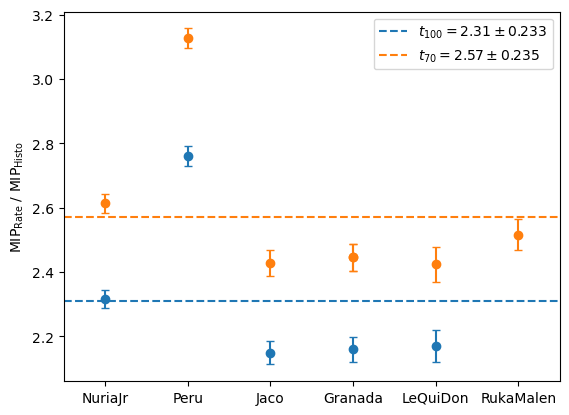

In [10]:
stations = ["NuriaJr", "Peru", "Jaco", "Granada", "LeQuiDon", "RukaMalen"]
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
color, ratios = {}, {}

for i, station in enumerate(stations):
    OFFLINE_MIP = offline_MIP(station)
    ONLINE_MIP = online_MIP(station)

    for mip in ONLINE_MIP:
        
        ratio = mip[1] / OFFLINE_MIP[0]
        error = np.sqrt( (mip[2]/OFFLINE_MIP[0])**2 + (mip[1]/OFFLINE_MIP[0]**2 * OFFLINE_MIP[1])**2 )

        try:
            _ = color[mip[0]]
            ratios[mip[0]].append(ratio)
        except KeyError:
            color[mip[0]] = len(color)
            ratios[mip[0]] = [ratio]

        plt.errorbar(i, ratio, yerr=error, color=cycle[color[mip[0]]], fmt='o', capsize=3)

for rate, c in color.items():
    plt.axhline(np.mean(ratios[rate]), c=cycle[c], ls='--', label=f"$t_{{{int(rate)}}} = {np.mean(ratios[rate]):.2f} \pm {np.std(ratios[rate]):.3f}$")
    plt.scatter([],[], color=cycle[c]) 

_ = plt.ylabel(r"MIP$_\mathrm{Rate}$ / MIP$_\mathrm{Histo}$")
plt.xticks(range(len(stations)), stations)
plt.xlim(-0.5, i + 0.5)
plt.legend()